# 4.2 Classification

Module - Deep Vision

For book, references and training materials, please check this project website [http://activefitness.ai/ai-in-sports-with-python](http://activefitness.ai/ai-in-sports-with-python).

Reference: Chapter 6, [Applied Machine Learning for Health and Fitness](https://www.apress.com/us/book/9781484257715)

['surfing', 'tennis']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


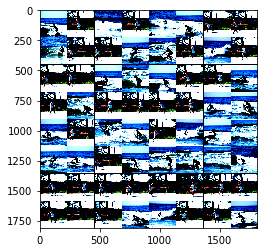

In [3]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data.sampler import SubsetRandomSampler

f = 'data/activities'

def load(f, size = .2):
    
    t = transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
        std = [0.229, 0.224, 0.225])])
        
    train = datasets.ImageFolder(f, transform=t)
    test = datasets.ImageFolder(f, transform=t)
    n = len(train)
    indices = list(range(n))
    split = int(np.floor(size * n))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train,sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load(f, .2)
print(trainloader.dataset.classes)
images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)
plt.imshow(grid.permute(1,2,0))

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

In [5]:
for param in model.parameters():
    param.requires_grad = False    

In [6]:
features = model.fc.in_features
model.fc = nn.Linear(features, len(labels))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
def train_model(epochs=3):
    total_loss = 0
    train_losses, test_losses = [], []
    i = 0
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            i += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(total_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {total_loss:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
    #plt.plot(train_losses, label='Training loss')
    #plt.plot(test_losses, label='Validation loss')
    #plt.legend(frameon=False)
    #plt.show()
    return model

model = train_model(epochs=3)
torch.save(model, 'activity_classifier_model.pth')

Epoch 1/3.. Train loss: 0.013.. Test loss: 0.020.. Test accuracy: 1.000
Epoch 1/3.. Train loss: 0.024.. Test loss: 0.020.. Test accuracy: 1.000
Epoch 1/3.. Train loss: 0.046.. Test loss: 0.021.. Test accuracy: 1.000
Epoch 2/3.. Train loss: 0.065.. Test loss: 0.022.. Test accuracy: 1.000
Epoch 2/3.. Train loss: 0.078.. Test loss: 0.021.. Test accuracy: 1.000
Epoch 2/3.. Train loss: 0.091.. Test loss: 0.021.. Test accuracy: 1.000
Epoch 3/3.. Train loss: 0.105.. Test loss: 0.021.. Test accuracy: 1.000
Epoch 3/3.. Train loss: 0.118.. Test loss: 0.020.. Test accuracy: 1.000
Epoch 3/3.. Train loss: 0.168.. Test loss: 0.022.. Test accuracy: 1.000


0
0
1
1
1


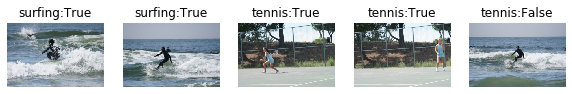

In [18]:
data_dir = 'data/activities/'
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('activity_classifier_model.pth')
model.eval()

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, classes

from torch.autograd import Variable

to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    print(index)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()